# **RNN**


**[Overview]**
1. 라이브러리 설정 
2. HyperParameter 설정 
3. GPU 설정 
4. Data 준비(Data 불러오기, Data 전처리, Tokenizing)
5. 모델 설계 
6. 모델 훈련 (Training)
7. 모델 검증 (Testing)

**1. 라이브러리**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader 
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

try:
    %tensorflow_version 2.x
except Exception:
    pass


import tensorflow as tf 
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
print(f'Pytorch version: {torch.__version__}')
import os

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Pytorch version: 1.13.1+cu116


**2. HyperParameter**

In [4]:
batch_size = 64
lr = 1e-4
epochs = 10
model_name = "RNN"
vocab_length = 7000
num_layers = 3
hidden_size = 256
num_classes = 2
embedding_size = 256
dropout = 0.1


#seed
random_seed = 9712
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
print(torch.randn(1, 3))

tensor([[0.3936, 0.5584, 0.9692]])


**3. GPU 설정**

In [5]:
! nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Wed Feb  8 02:13:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**4. Data 준비**

* Data 불러오기

In [6]:
train_data = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", delimiter='\t').dropna()
test_data = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", delimiter='\t').dropna()
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))
print(train_data)

훈련용 리뷰 개수 : 149995
테스트용 리뷰 개수 : 49997
              id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[149995 rows x 3 columns]


* Data text, label로 나누기

In [ ]:
train_text, train_label = train_data.iloc[:, 1], train_data.iloc[:, 2]
test_text, test_label = test_data.iloc[:, 1], test_data.iloc[:, 2]

print("[Text]")
print(train_text)
print()
print("[Label]")
print(train_label)

[Text]
0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 149995, dtype: object

[Label]
0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 149995, dtype: int64


* Tokenizing

문장: 아 더빙.. 진짜 짜증나네요 목소리
텍스트 정제 후: 아 더빙 진짜 짜증나네요 목소리
띄어쓰기 단위로 분리 후: ['아', '더빙', '진짜', '짜증나네요', '목소리']
Tokenizer 후: [26, 898, 8, 6750, 1094]


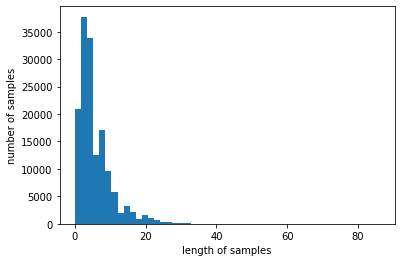

Padding 후: [  26  898    8 6750 1094    0    0    0    0    0    0    0    0    0
    0]


In [ ]:
# Tokenizing을 위한 Text 정제 작업 
import re 
def clean_str(string):
    # From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string) 
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)
    return string.lower()


print("문장:", train_text[0])

#텍스트 정제 작업
train_x = [clean_str(x) for x in train_text]
test_x = [clean_str(x) for x in test_text]
print("텍스트 정제 후:", train_x[0])

#문장을 띄어쓰기 단위로 분리
train_x = [x.split(' ') for x in train_x]
test_x = [x.split(' ') for x in test_x]
print("띄어쓰기 단위로 분리 후:", train_x[0])

#Tokenizer 만들기
tokenizer = Tokenizer(num_words = vocab_length) 
tokenizer.fit_on_texts(train_x)

#Tokenizer 
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)
print("Tokenizer 후:", train_x[0])


# max len 
plt.hist([len(review) for review in train_x], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


#Padding
train_x = pad_sequences(train_x, padding='post',maxlen=15)
test_x = pad_sequences(test_x, padding='post', maxlen=15) #훈련 데이터 중 max_length로 padding된다. 
print("Padding 후:", train_x[0])



* Vocab 확인

In [ ]:
print("26:", tokenizer.index_word[26])
print("898:", tokenizer.index_word[898])
print("8:", tokenizer.index_word[8])
print("1094:", tokenizer.index_word[1094])

26: 아
898: 더빙
8: 진짜
1094: 목소리


* Dataset, Dataloader 준비


In [ ]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels
    def __getitem__(self, idx):
        x = self.datas[idx]
        y = self.labels[idx]
        return x, y
    def __len__(self):
        return len(self.labels)

train_y = np.array(train_label)
train_dataset = MyDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True )

test_y = np.array(test_label)
test_dataset = MyDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)


print(f"[Dataset] train: {len(train_dataset)}, test: {len(test_dataset)}")
print(f"[DataLoader] train: {len(train_dataloader)}, test: {len(test_dataloader)}")



[Dataset] train: 149995, test: 49997
[DataLoader] train: 2344, test: 49997


**5. Model 설계**

In [ ]:

class RNN(nn.Module):
    def __init__(self, vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout):  
        super(RNN, self).__init__()
        print("Model=RNN")
        self.embedding_layer = nn.Embedding(vocab_length, embedding_size, padding_idx =0) #입력 문장을 벡터화 시킨다 
        self.rnn = nn.RNN(input_size=embedding_size,  hidden_size=hidden_size, num_layers=num_layers,  batch_first= True,  dropout=dropout)
        self.classifier_linear = nn.Linear(hidden_size, num_classes)

    
    def forward(self, x):
        embed = self.embedding_layer(x)
        rnn_output, _ = self.rnn(embed)
        cut_output = rnn_output[:, -1, :]
        cla_output = self.classifier_linear(cut_output)
        return cla_output
        """
        x = (batch_size, max_len)
        embed = (batch_size, max_len, embedding_size)
        rnn_output =  (batch_size, max_len, hidden_size)
        cut_output = (batch_size, hidden_size)
        cla_output =  (batch_size, num_classes)
        """

class LSTM(nn.Module):
    def __init__(self, vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout):  
        super(LSTM, self).__init__()
        print("Model=LSTM")
        self.embedding_layer = nn.Embedding(vocab_length, hidden_size, padding_idx =0) 
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers,  batch_first= True,  dropout=dropout)
        self.classifier_linear = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        embed = self.embedding_layer(x)
        lstm_output, _ = self.lstm(embed)
        cut_output = lstm_output[:, -1, :]
        cla_output = self.classifier_linear(cut_output)
        return cla_output
        """
        x = (batch_size, max_len)
        embed = (batch_size, max_len, embedding_size)
        lstm_output =  (batch_size, max_len, hidden_size)
        cut_output = (batch_size, hidden_size)
        cla_output =  (batch_size, num_classes)
        """


class GRU(nn.Module):
    def __init__(self, vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout):  
        super(GRU, self).__init__()
        print("Model=GRU")
        self.embedding_layer = nn.Embedding(vocab_length, hidden_size, padding_idx =0) 
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers,  batch_first= True,  dropout=dropout)
        self.classifier_linear = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        embed = self.embedding_layer(x)
        lstm_output, _ = self.gru(embed)
        cut_output = lstm_output[:, -1, :]
        cla_output = self.classifier_linear(cut_output)
        return cla_output
        """
        x = (batch_size, max_len)
        embed = (batch_size, max_len, embedding_size)
        lstm_output =  (batch_size, max_len, hidden_size)
        cut_output = (batch_size, hidden_size)
        cla_output =  (batch_size, num_classes)
        """



* Model 불러오기 

In [ ]:
if model_name == "RNN":
    model = RNN(vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout)
elif model_name == "LSTM":
    model = LSTM(vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout)
elif model_name == "GRU":
    model = GRU(vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout)

model = model.to(device)

Model=RNN


**6. Model 훈련(Training)** 

In [ ]:
loss_fnc = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
tot_train_loss  = []
for e in range(1, epochs+1):
    train_loss = 0.0
    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data) #(batch_size, 2)
        loss = loss_fnc(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    tot_train_loss.append(train_loss/len(train_dataloader))
    print(f"epoch:{e}/{epochs} loss: {train_loss/len(train_dataloader):.9f}")

  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:1/10 loss: 0.596879745


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:2/10 loss: 0.516919536


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:3/10 loss: 0.474181188


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:4/10 loss: 0.444816024


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:5/10 loss: 0.424097015


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:6/10 loss: 0.408154635


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:7/10 loss: 0.394103096


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:8/10 loss: 0.381859950


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:9/10 loss: 0.370892132


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:10/10 loss: 0.361574267


**7. Model 검증(Testing)**

In [ ]:
with torch.no_grad():
    model.eval()
    test_acc = 0.0
    for data, label in tqdm(test_dataloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data) #(batch, 2)
        preds = torch.argmax(output, dim=1)
        test_acc += preds.eq(label).sum().item()
    print(f"test acc: {test_acc/len(test_dataloader.dataset)*100}%")




  0%|          | 0/49997 [00:00<?, ?it/s]

test acc: 78.63671820309219%
